In [1]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import linregress
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import json

import psycopg2
import pandas as pd

import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost, getStatValues,density_plot, get_mdfps,density_plot_multiple,train_pred_xgboost_2d
from functools import reduce
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
#disable futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
df = pd.read_csv('mdfp_and_rdkit_features_2980.csv')
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/molregno_to_molblock_2D.pickle', 'rb') as handle:
    molregno_to_molblock_2d = pickle.load(handle)
df['molblock'] = df['molregno'].apply(lambda x: molregno_to_molblock_2d[x])

In [3]:
molblocks = df['molblock'].tolist()
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mols = [Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mol))) for mol in mols]

In [4]:
from serenityff.charge.tree.dash_tree import DASHTree
tree = DASHTree(tree_folder_path="/localhome/cschiebroek/other/props")

Loading DASH tree data


DASHprop features:
1. Min/max/std partial charge
2. Counts: N atom < -0.5, > 0.5
3. HOMO LUMO (mean)

In [5]:
Dash_prop_dict = [tree.get_DASH_feature_dict_for_mol(mol) for mol in mols]

In [8]:
partial_charges = [feature_vec[:,0] for feature_vec in DASH_props]
max_partial_charge = [np.max(pc) for pc in partial_charges]
min_partial_charge = [np.min(pc) for pc in partial_charges]
std_partial_charge = [np.std(pc) for pc in partial_charges]
count_lower_minus_0_5 = [len([p for p in pc if p < -0.5]) for pc in partial_charges]
count_higher_plus_0_5 = [len([p for p in pc if p > 0.5]) for pc in partial_charges]

In [9]:
HOMO = [np.mean(feature_vec[:,2]) for feature_vec in  DASH_props]
LUMO = [np.mean(feature_vec[:,3])for feature_vec in  DASH_props]

In [10]:
dual = [feature_vec[:,1] for feature_vec in DASH_props]
dual_plus_0_1 = [len([p for p in pc if p > 0.1]) for pc in dual]
dual_minus_0_1 = [len([p for p in pc if p < -0.1]) for pc in dual]

In [11]:
#add these features to df
df['DASHPROP_max_pc'] = max_partial_charge
df['DASHPROP_min_pc'] = min_partial_charge
df['DASHPROP_std_pc'] = std_partial_charge
df['DASHPROP_pc_count_minus_0_5'] = count_lower_minus_0_5
df['DASHPROP_pc_count_plus_0_5'] = count_higher_plus_0_5
df['DASHPROP_HOMO'] = HOMO
df['DASHPROP_LUMO'] = LUMO
df['DASHPROP_nucleophile'] = dual_plus_0_1
df['DASHPROP_electrophiles'] = dual_minus_0_1

#save
df.to_csv('mdfp_and_rdkit_features_2993_DASHprops.csv')


In [12]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}

In [13]:
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfp_features_full = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
DASH_props_names = [c for c in df.columns.tolist() if 'DASHPROP' in c]


In [14]:
output_2d_only = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names,y_label='vp')
real_2d_only, prediction_2d_only = (reduce(lambda a,b : list(a)+list(b) , output_2d_only[0]), reduce(lambda a,b : list(a)+list(b), output_2d_only[1]))

In [15]:
output_mdfp_only = train_pred_xgboost_2d(df,params=params,X_features=mdfp_features_full,y_label='vp')
real_mdfp_only, prediction_mdfp_only = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_only[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_only[1]))

In [16]:
output_physchem_plus_dash = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names+DASH_props_names,y_label='vp')
real_physchem_plus_dash, prediction_physchem_plus_dash = (reduce(lambda a,b : list(a)+list(b) , output_physchem_plus_dash[0]), reduce(lambda a,b : list(a)+list(b), output_physchem_plus_dash[1]))

In [17]:
output_mdfp_plus_dash = train_pred_xgboost_2d(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp')
real_mdfp_plus_dash, prediction_mdfp_plus_dash = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_plus_dash[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_plus_dash[1]))

In [18]:
output_dash_only = train_pred_xgboost_2d(df,params=params,X_features=DASH_props_names,y_label='vp')
real_dash_only, prediction_dash_only = (reduce(lambda a,b : list(a)+list(b) , output_dash_only[0]), reduce(lambda a,b : list(a)+list(b), output_dash_only[1]))

In [19]:
dash_plus_MolWt = train_pred_xgboost_2d(df,params=params,X_features=['MolWt']+DASH_props_names,y_label='vp')
real_dash_plus_MolWt, prediction_dash_plus_MolWt = (reduce(lambda a,b : list(a)+list(b) , dash_plus_MolWt[0]), reduce(lambda a,b : list(a)+list(b), dash_plus_MolWt[1]))

In [20]:
mwt_only = train_pred_xgboost_2d(df,params=params,X_features=['MolWt'],y_label='vp')
real_MolWt, prediction_MolWt = (reduce(lambda a,b : list(a)+list(b) , mwt_only[0]), reduce(lambda a,b : list(a)+list(b), mwt_only[1]))

Plot 1 Stats:
RMSE:  1.2448420029546392
MAE:  0.7615872683372399
R2:  0.8818347555667281
Plot 2 Stats:
RMSE:  1.4298174450850358
MAE:  0.9025526456470268
R2:  0.8439799763444357
Plot 3 Stats:
RMSE:  1.2304919927312001
MAE:  0.7577541428783132
R2:  0.8844805168501176
Plot 4 Stats:
RMSE:  1.3792727622010421
MAE:  0.8711061192548653
R2:  0.854813433564641


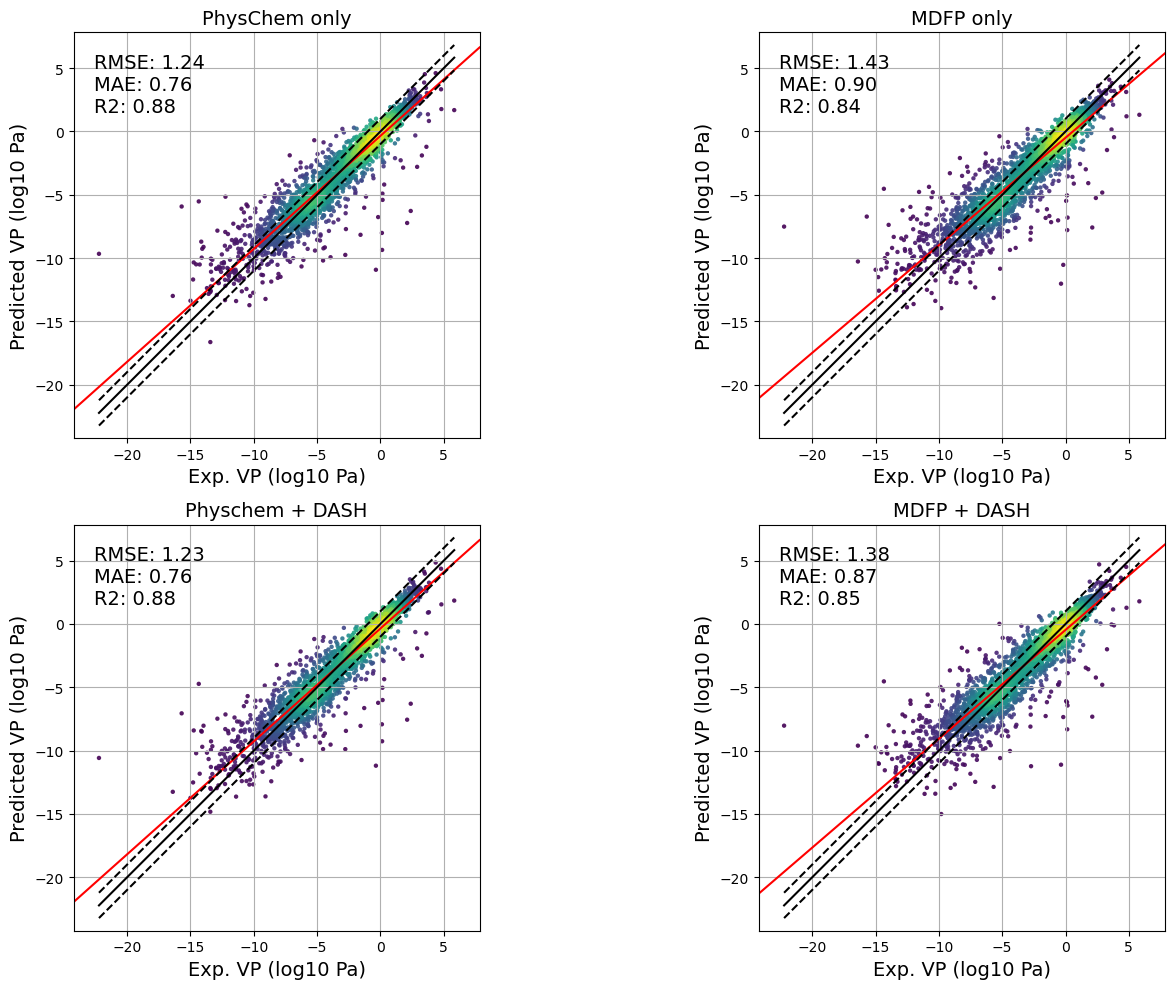

In [21]:
density_plot_multiple(reals = [real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash],
                      predictions = [prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash],
                      titles = ['PhysChem only','MDFP only','Physchem + DASH','MDFP + DASH'])

Plot 1 Stats:
RMSE:  1.2448420029546392
MAE:  0.7615872683372399
R2:  0.8818347555667281
Plot 2 Stats:
RMSE:  1.4298174450850358
MAE:  0.9025526456470268
R2:  0.8439799763444357
Plot 3 Stats:
RMSE:  1.2304919927312001
MAE:  0.7577541428783132
R2:  0.8844805168501176
Plot 4 Stats:
RMSE:  1.3792727622010421
MAE:  0.8711061192548653
R2:  0.854813433564641
Plot 5 Stats:
RMSE:  2.0647960030638126
MAE:  1.5380578172281927
R2:  0.6746064923090911
Plot 6 Stats:
RMSE:  1.6456794110853388
MAE:  1.1403532501855809
R2:  0.793383900689499
Plot 7 Stats:
RMSE:  2.269376792160368
MAE:  1.6303028290830275
R2:  0.6068931695827802


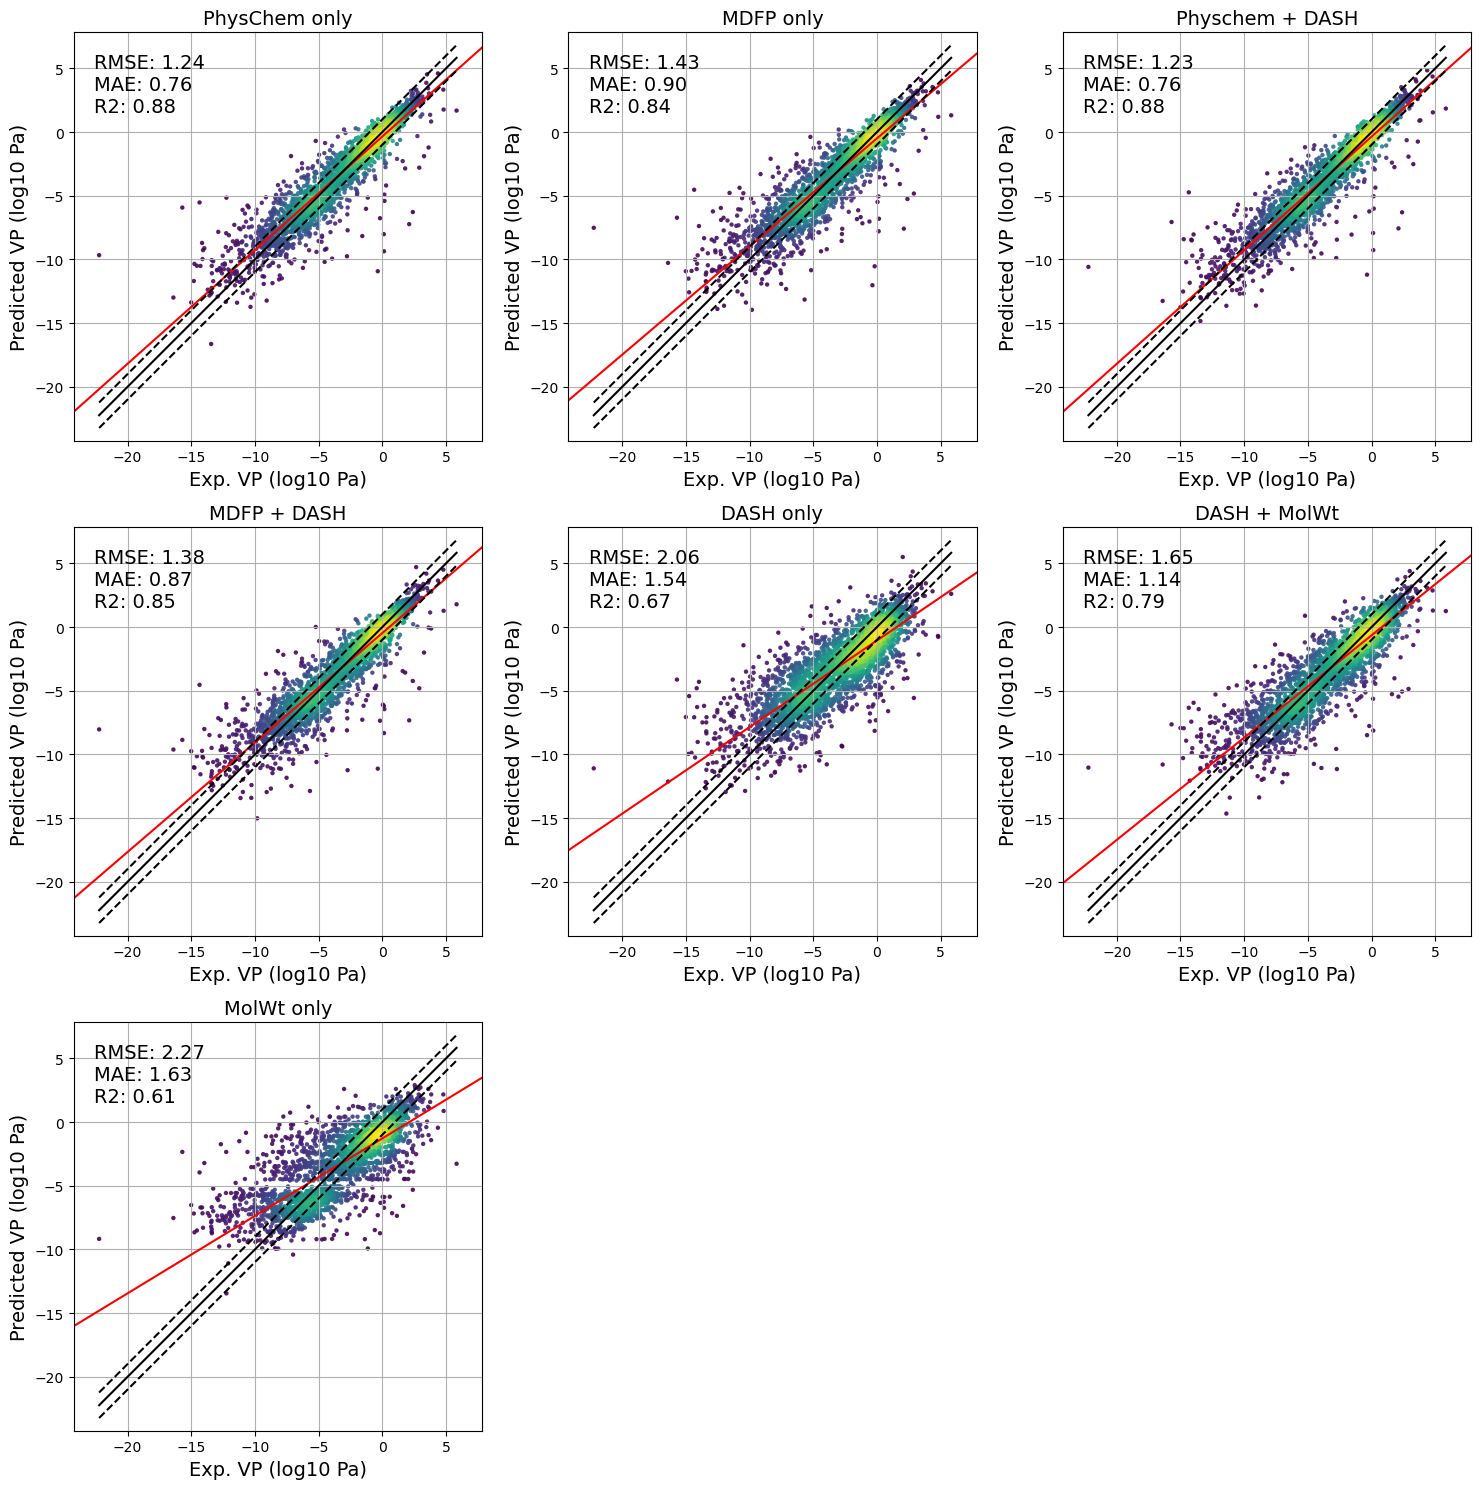

In [22]:
density_plot_multiple(reals = [real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash, real_dash_only, real_dash_plus_MolWt, real_MolWt],
                      predictions = [prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash, prediction_dash_only, prediction_dash_plus_MolWt, prediction_MolWt],
                      titles = ['PhysChem only','MDFP only','Physchem + DASH','MDFP + DASH','DASH only','DASH + MolWt','MolWt only'])

In [23]:

def train_pred_xgboost_2d_local(df,params,X_features,y_label,splits=5,scale = True):

    X = df[X_features]
    X = X.to_numpy()
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    y = df[y_label]
    kf = KFold(n_splits=splits)
    output = ([], [])

    for train, test in kf.split(X):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)

            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
            )

            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)

    return output,model

In [24]:
output_dash_only,model_dash_only = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp')
importance = model_dash_only.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
importance = {DASH_props_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance



[('DASHPROP_std_pc', 79.0),
 ('DASHPROP_max_pc', 62.0),
 ('DASHPROP_min_pc', 53.0),
 ('DASHPROP_LUMO', 50.0),
 ('DASHPROP_HOMO', 42.0),
 ('DASHPROP_pc_count_minus_0_5', 17.0),
 ('DASHPROP_electrophiles', 15.0),
 ('DASHPROP_nucleophile', 13.0),
 ('DASHPROP_pc_count_plus_0_5', 10.0)]

In [25]:
output_dash_only,model_dash_only = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp')
importance = model_dash_only.get_score(importance_type='gain')
#use actual feature names: DASH_props_names
importance = {DASH_props_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance

[('DASHPROP_pc_count_plus_0_5', 538.9358520507812),
 ('DASHPROP_pc_count_minus_0_5', 318.8323059082031),
 ('DASHPROP_electrophiles', 280.15478515625),
 ('DASHPROP_nucleophile', 145.6353759765625),
 ('DASHPROP_LUMO', 142.50999450683594),
 ('DASHPROP_max_pc', 112.32049560546875),
 ('DASHPROP_std_pc', 112.11038970947266),
 ('DASHPROP_HOMO', 85.11825561523438),
 ('DASHPROP_min_pc', 77.16867065429688)]

In [26]:
output_mdfp_plus_dash,model_mdfp_plus_dash = train_pred_xgboost_2d_local(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp')
importance = model_mdfp_plus_dash.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
dash_plus_mdfp_names  = mdfp_features_full+DASH_props_names
importance = {dash_plus_mdfp_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance





[('NumHeavyAtoms', 24.0),
 ('water_total_lj_std', 16.0),
 ('DASHPROP_LUMO', 16.0),
 ('water_total_ene_std', 14.0),
 ('water_intra_lj_std', 13.0),
 ('NumRotatableBonds', 12.0),
 ('water_rgyr_mean', 12.0),
 ('NumF', 10.0),
 ('water_total_crf_std', 10.0),
 ('NumN', 9.0),
 ('water_rgyr_std', 8.0),
 ('water_sasa_std', 8.0),
 ('DASHPROP_max_pc', 8.0),
 ('DASHPROP_min_pc', 8.0),
 ('DASHPROP_std_pc', 8.0),
 ('DASHPROP_HOMO', 8.0),
 ('water_sasa_mean', 7.0),
 ('water_intra_lj_mean', 6.0),
 ('NumBr', 5.0),
 ('water_intra_crf_mean', 5.0),
 ('NumO', 4.0),
 ('water_intra_crf_std', 4.0),
 ('water_total_lj_mean', 4.0),
 ('water_intra_ene_std', 4.0),
 ('water_rgyr_median', 4.0),
 ('NumCl', 3.0),
 ('water_total_lj_median', 3.0),
 ('water_intra_ene_mean', 3.0),
 ('water_total_ene_mean', 3.0),
 ('DASHPROP_electrophiles', 3.0),
 ('NumI', 2.0),
 ('water_total_crf_mean', 2.0),
 ('DASHPROP_nucleophile', 2.0),
 ('NumS', 1.0),
 ('water_intra_crf_median', 1.0),
 ('water_intra_lj_median', 1.0),
 ('water_total_en

In [27]:
output_mdfp_plus_dash,model_mdfp_plus_dash = train_pred_xgboost_2d_local(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp')
importance = model_mdfp_plus_dash.get_score(importance_type='gain')
#use actual feature names: DASH_props_names
dash_plus_mdfp_names  = mdfp_features_full+DASH_props_names
importance = {dash_plus_mdfp_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance



[('NumHeavyAtoms', 1517.88330078125),
 ('water_total_ene_std', 363.844970703125),
 ('water_total_crf_std', 290.6661071777344),
 ('NumN', 154.29965209960938),
 ('water_total_lj_std', 142.00619506835938),
 ('water_intra_lj_mean', 108.25653839111328),
 ('water_sasa_mean', 87.93794250488281),
 ('NumF', 82.40177154541016),
 ('water_sasa_std', 78.98145294189453),
 ('DASHPROP_LUMO', 64.6285629272461),
 ('water_rgyr_mean', 50.273040771484375),
 ('NumS', 47.84580612182617),
 ('NumBr', 46.39550018310547),
 ('water_intra_ene_std', 45.88075637817383),
 ('NumRotatableBonds', 43.256591796875),
 ('water_total_crf_mean', 40.587120056152344),
 ('NumCl', 37.95525360107422),
 ('DASHPROP_max_pc', 33.5411491394043),
 ('DASHPROP_min_pc', 31.453975677490234),
 ('water_rgyr_median', 28.1790828704834),
 ('water_intra_lj_std', 27.419355392456055),
 ('DASHPROP_HOMO', 25.03231430053711),
 ('water_intra_crf_median', 24.723384857177734),
 ('DASHPROP_electrophiles', 21.59236717224121),
 ('water_intra_ene_mean', 20.8

In [28]:
#replace estate by dashprops
custom_estate = RDKit_feature_names.copy()
custom_estate = [f for f in custom_estate if 'EState' not in f]
custom_estate = [f for f in custom_estate if 'Charge' not in f]
custom_estate += DASH_props_names
custom_estate

['qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'S

Plot 1 Stats:
RMSE:  1.2448420029546392
MAE:  0.7615872683372399
R2:  0.8818347555667281
Plot 2 Stats:
RMSE:  1.2268476671633788
MAE:  0.7525787483602195
R2:  0.8852193660175401


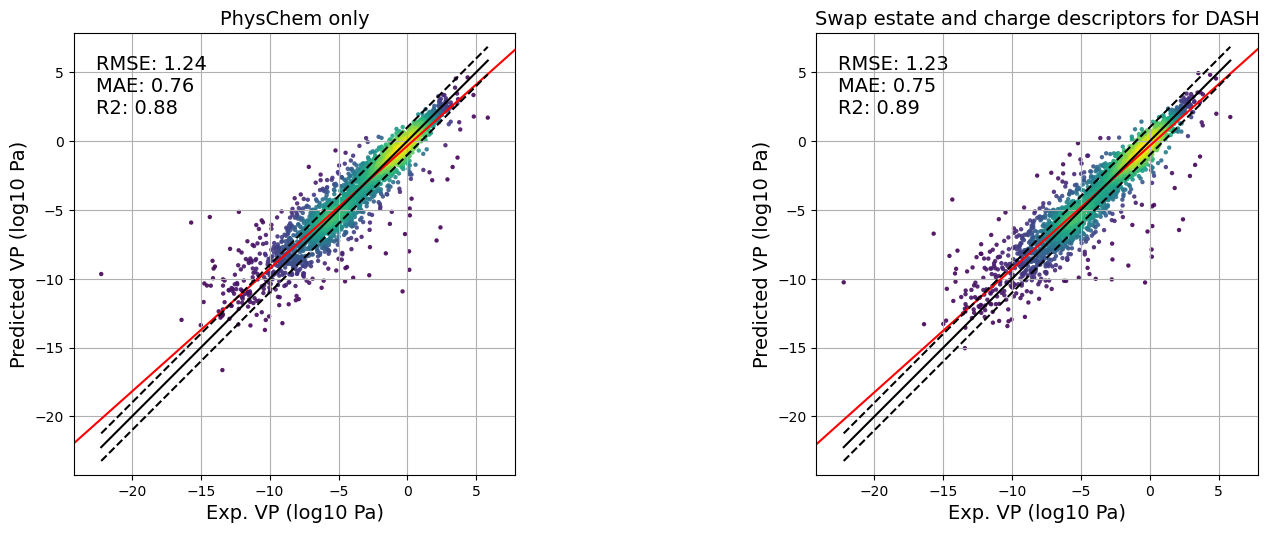

In [29]:
custom_estate_out,model_custom_estate = train_pred_xgboost_2d_local(df,params=params,X_features=custom_estate,y_label='vp')
realcustom_estate, prediction_custom_estate = (reduce(lambda a,b : list(a)+list(b) , custom_estate_out[0]), reduce(lambda a,b : list(a)+list(b), custom_estate_out[1]))
density_plot_multiple(reals = [real_2d_only,realcustom_estate],
                      predictions = [prediction_2d_only,prediction_custom_estate],
                      titles = ['PhysChem only','Swap estate and charge descriptors for DASH'])

In [30]:
importance = model_custom_estate.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
importance = {custom_estate[int(k[1:])]:v for k,v in importance.items()}
importance_list = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance_list



[('TPSA', 20.0),
 ('BalabanJ', 17.0),
 ('Chi1v', 17.0),
 ('DASHPROP_min_pc', 17.0),
 ('DASHPROP_std_pc', 15.0),
 ('DASHPROP_LUMO', 14.0),
 ('BCUT2D_MWLOW', 13.0),
 ('BCUT2D_LOGPLOW', 12.0),
 ('BCUT2D_MRLOW', 12.0),
 ('PEOE_VSA7', 12.0),
 ('SlogP_VSA2', 12.0),
 ('MolMR', 12.0),
 ('DASHPROP_max_pc', 12.0),
 ('BCUT2D_CHGLO', 11.0),
 ('Chi2n', 11.0),
 ('Kappa1', 11.0),
 ('Kappa2', 11.0),
 ('DASHPROP_HOMO', 11.0),
 ('qed', 10.0),
 ('AvgIpc', 10.0),
 ('PEOE_VSA10', 10.0),
 ('SMR_VSA2', 10.0),
 ('NHOHCount', 10.0),
 ('BCUT2D_MWHI', 9.0),
 ('SMR_VSA1', 9.0),
 ('Chi3v', 7.0),
 ('PEOE_VSA14', 7.0),
 ('PEOE_VSA2', 7.0),
 ('PEOE_VSA8', 7.0),
 ('BertzCT', 6.0),
 ('PEOE_VSA1', 6.0),
 ('PEOE_VSA3', 6.0),
 ('SMR_VSA4', 6.0),
 ('SlogP_VSA3', 6.0),
 ('SlogP_VSA6', 6.0),
 ('FractionCSP3', 6.0),
 ('HeavyAtomCount', 6.0),
 ('FpDensityMorgan2', 5.0),
 ('FpDensityMorgan3', 5.0),
 ('BCUT2D_CHGHI', 5.0),
 ('Chi0', 5.0),
 ('Chi4v', 5.0),
 ('PEOE_VSA9', 5.0),
 ('SMR_VSA10', 5.0),
 ('SMR_VSA3', 5.0),
 ('NumHDonor

In [31]:
df.head()
df_electro = df.copy()
#get dash props and everything with 'estate' or 'charge' in column name
dash_plus_electro = [c for c in df_electro.columns.tolist() if 'DASHPROP' in c or 'EState' in c or 'Charge' in c]
dash_plus_electro = dash_plus_electro + ['molblock']
dash_plus_electro_df = df_electro[dash_plus_electro]
dash_plus_electro_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,EState_VSA1,EState_VSA10,...,DASHPROP_max_pc,DASHPROP_min_pc,DASHPROP_std_pc,DASHPROP_pc_count_minus_0_5,DASHPROP_pc_count_plus_0_5,DASHPROP_HOMO,DASHPROP_LUMO,DASHPROP_nucleophile,DASHPROP_electrophiles,molblock
0,8.278588,8.278588,1.227955,-4.010932,0.062213,-0.095843,0.095843,0.062213,62.445836,0.000000,...,0.179199,-0.435547,0.208366,0,0,-0.209966,-0.033166,1,0,\n RDKit 2D\n\n 10 10 0 0 0 0...
1,7.449583,7.449583,3.420840,-3.969792,0.210037,-0.396377,0.396377,0.210037,38.902577,0.000000,...,0.461182,-0.687988,0.238725,1,0,-0.251170,0.037836,0,1,\n RDKit 2D\n\n 7 6 0 0 0 0...
2,8.560843,8.560843,0.020648,-2.797595,0.161130,-0.372300,0.372300,0.161130,42.396339,0.000000,...,0.401367,-0.534668,0.273793,1,0,-0.191597,-0.043258,0,1,\n RDKit 2D\n\n 10 10 0 0 0 0...
3,11.649018,11.649018,0.734623,-3.552775,0.321267,-0.397905,0.397905,0.321267,48.656310,9.589074,...,0.945801,-0.698242,0.414752,4,2,-0.223682,-0.079919,3,1,\n RDKit 2D\n\n 14 13 0 0 0 0...
4,7.904480,7.904480,0.039061,-0.571335,0.141178,-0.456191,0.456191,0.141178,35.961605,0.000000,...,0.331543,-0.320557,0.196873,0,0,-0.217282,-0.056579,1,2,\n RDKit 2D\n\n 15 16 0 0 0 0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,8.024563,8.024563,0.030679,-0.279202,0.155107,-0.452854,0.452854,0.155107,0.000000,0.000000,...,0.341309,-0.222168,0.171188,0,0,-0.207570,-0.068931,5,0,\n RDKit 2D\n\n 17 19 0 0 0 0...
2989,7.904953,7.904953,0.119126,-0.478091,0.148717,-0.454120,0.454120,0.148717,18.127256,0.000000,...,0.427246,-0.314453,0.190072,0,0,-0.215192,-0.071561,1,2,\n RDKit 2D\n\n 19 20 0 0 0 0...
2990,13.499884,13.499884,2.385185,-5.022647,0.155262,-0.294874,0.294874,0.155262,105.192468,7.536054,...,0.593262,-0.621094,0.264089,2,1,-0.218055,-0.045740,2,0,\n RDKit 2D\n\n 18 20 0 0 0 0...
2991,11.020753,11.020753,2.148884,-3.868171,0.211211,-0.393579,0.393579,0.211211,31.061251,4.794537,...,0.475830,-0.671875,0.395328,5,0,-0.214152,-0.047409,0,0,\n RDKit 2D\n\n 10 9 0 0 0 0...


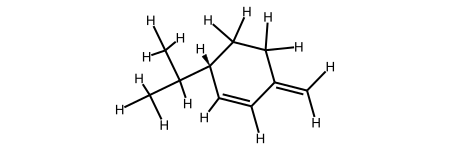

In [32]:
molblocks = dash_plus_electro_df['molblock'].tolist()
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mol1 = Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mols[0])))
mol1

In [33]:
from rdkit.Chem import Descriptors
rdkit_descriptors = Descriptors.CalcMolDescriptors(mol1)
dash_props = np.array(tree.get_molecules_feature_vector(mol1, verbose=False))

In [34]:
print(f'MaxPartialCharge rdkit: ' , np.round(rdkit_descriptors['MaxPartialCharge'],3),'MaxPartialCharge DASH:', np.round(max(dash_props[:,0]),3))

print(f'MinPartialCharge rdkit: ' , np.round(rdkit_descriptors['MinPartialCharge'],3),'MinPartialCharge DASH:', np.round(min(dash_props[:,0]),3))

MaxPartialCharge rdkit:  0.062 MaxPartialCharge DASH: 0.179
MinPartialCharge rdkit:  -0.096 MinPartialCharge DASH: -0.436


In [79]:
# dashprop_dicts = [tree.get_DASH_feature_dict_for_mol(mol) for mol in mols]
tree_failures = []
for i,mol in enumerate(mols):
    try:
        tree.get_DASH_feature_dict_for_mol(mol)
    except:
        print(f'Error for mol {i}')
        tree_failures.append(mol)

Error for mol 150
Error for mol 378
Error for mol 1788
Error for mol 2419
Error for mol 2664
Error for mol 2786


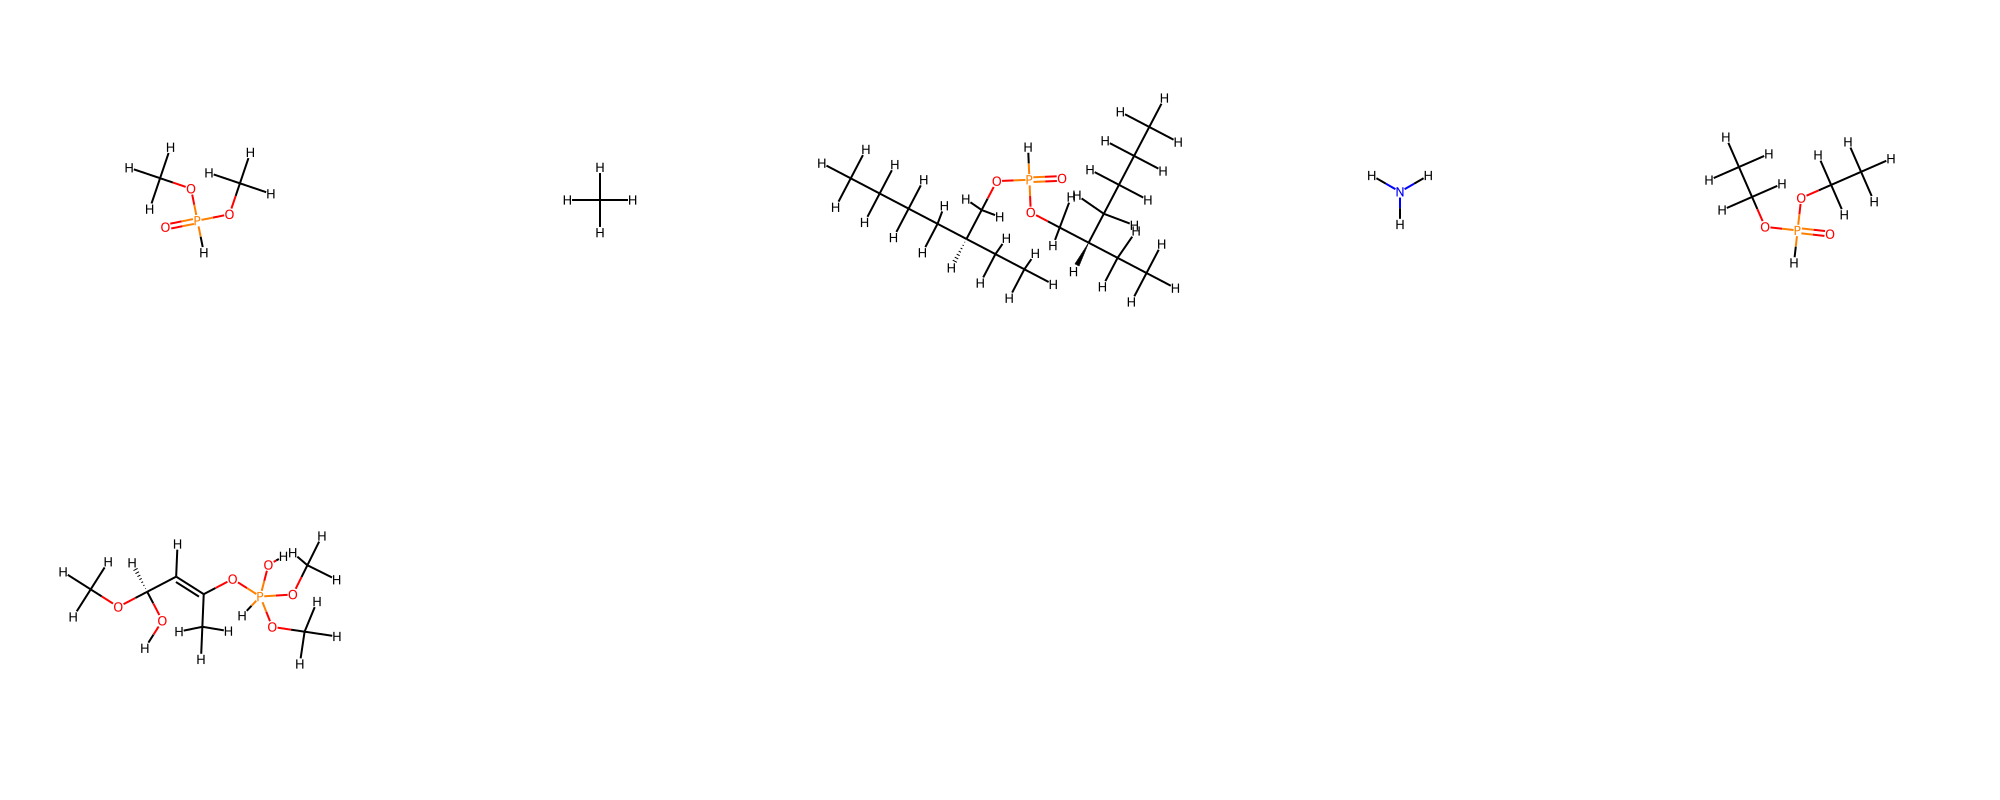

In [84]:
Draw.MolsToGridImage(tree_failures,molsPerRow=5,subImgSize=(400,400))


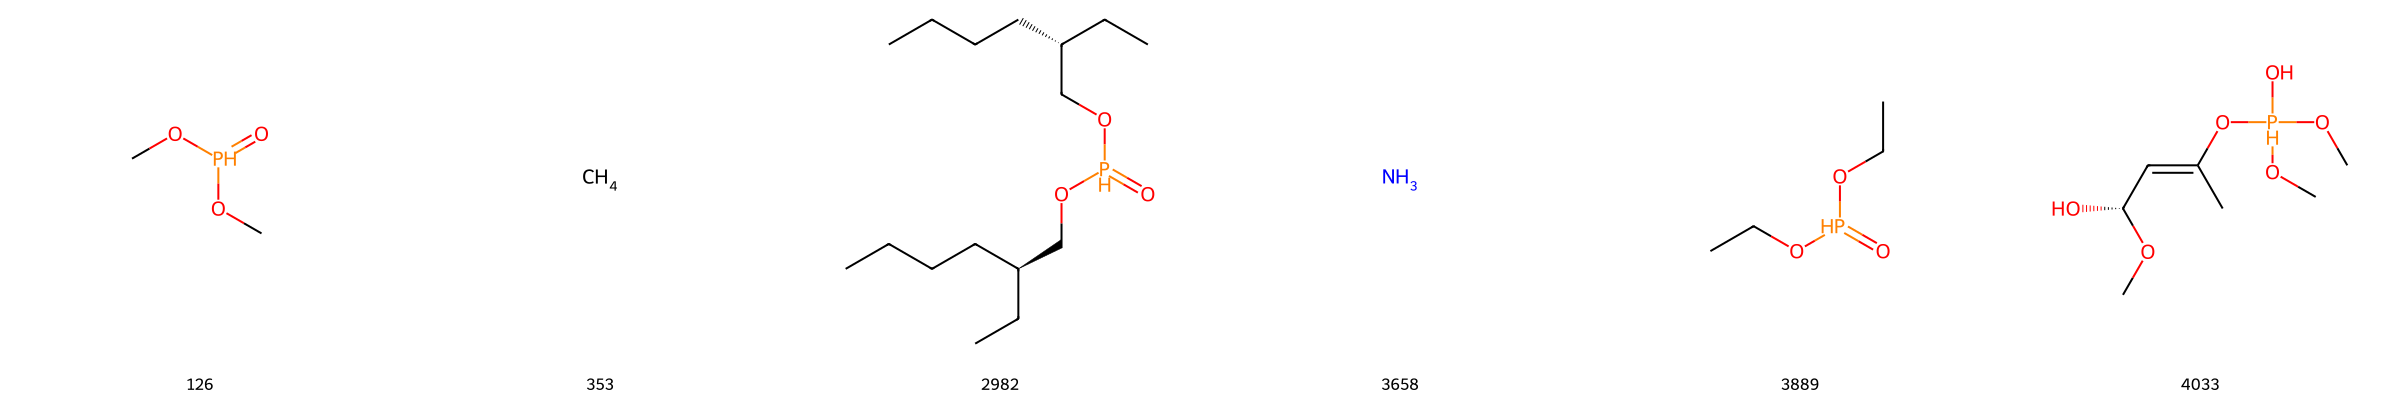

In [81]:
Draw.MolsToGridImage(tree_failures,molsPerRow=5,subImgSize=(400,400))
#print mol indexes
idxs = [mols.index(mol) for mol in tree_failures]
idxs
molregnos_to_check = [df['molregno'].tolist()[idx] for idx in idxs]
#double check
mols_to_check = [molregno_to_molblock_2d[molregno] for molregno in molregnos_to_check]
mols_to_check = [Chem.MolFromMolBlock(molblock) for molblock in mols_to_check]
Draw.MolsToGridImage(mols_to_check,molsPerRow=6,subImgSize=(400,400),legends=[f'{molregno}' for molregno in molregnos_to_check])

In [82]:
test = tree.get_molecules_feature_vector(mols_to_check[0], verbose=True)
print(len(test))
test[2]

['result', 'dual', 'homo', 'lumo', 'mbis_dipole_strength']
6


[nan, nan, nan, nan, nan]

In [83]:
tree.get_DASH_feature_dict_for_mol(mols_to_check[0])

KeyError: (15, 3, 0, False, 1)